<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/student_pgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The (simplified) student Bayes net

This model is from https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb

In [1]:
# import probml_utils as pml
try:
    import probml_utils.pgmpy_utils as pgm
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils.pgmpy_utils as pgm

  Using cached pgmpy-0.1.18-py3-none-any.whl (1.9 MB)


In [2]:
try:
    from causalgraphicalmodels import CausalGraphicalModel
except ModuleNotFoundError:
    %pip install -qq causalgraphicalmodels
    from causalgraphicalmodels import CausalGraphicalModel
try:
    import pgmpy
except ModuleNotFoundError:
    %pip install -qq pgmpy
    import pgmpy
import numpy as np
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


# Model



<img src="https://user-images.githubusercontent.com/4632336/118884310-21bec180-b8ab-11eb-81cf-481553c21d8a.png?raw=true">


In [3]:
try:
    from pgmpy.models import BayesianModel
except ModuleNotFoundError:
    %pip install -qq pgmpy
    from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
#model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])
model = BayesianModel([('Diff', 'Grade'), ('Intel', 'Grade'), ('Grade', 'Letter'), ('Intel', 'SAT')])



/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


## Basic CPDs

In [4]:
# Defining individual CPDs.
cpd_d = TabularCPD(variable="Diff", variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable="Intel", variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.3, 0.05, 0.9, 0.5], [0.4, 0.25, 0.08, 0.3], [0.3, 0.7, 0.02, 0.2]],
    evidence=["Intel", "Diff"],
    evidence_card=[2, 2],
)

cpd_l = TabularCPD(
    variable="Letter",
    variable_card=2,
    values=[[0.1, 0.4, 0.99], [0.9, 0.6, 0.01]],
    evidence=["Grade"],
    evidence_card=[3],
)

cpd_s = TabularCPD(
    variable="SAT", variable_card=2, values=[[0.95, 0.2], [0.05, 0.8]], evidence=["Intel"], evidence_card=[2]
)

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

True

In [5]:
print(model.get_cpds("Grade"))

+----------+----------+----------+----------+----------+
| Intel    | Intel(0) | Intel(0) | Intel(1) | Intel(1) |
+----------+----------+----------+----------+----------+
| Diff     | Diff(0)  | Diff(1)  | Diff(0)  | Diff(1)  |
+----------+----------+----------+----------+----------+
| Grade(0) | 0.3      | 0.05     | 0.9      | 0.5      |
+----------+----------+----------+----------+----------+
| Grade(1) | 0.4      | 0.25     | 0.08     | 0.3      |
+----------+----------+----------+----------+----------+
| Grade(2) | 0.3      | 0.7      | 0.02     | 0.2      |
+----------+----------+----------+----------+----------+


## CPDs with names states

In [6]:
# CPDs can also be defined using the state names of the variables. If the state names are not provided
# like in the previous example, pgmpy will automatically assign names as: 0, 1, 2, ....

cpd_d_sn = TabularCPD(variable="Diff", variable_card=2, values=[[0.6], [0.4]], state_names={"Diff": ["Easy", "Hard"]})
cpd_i_sn = TabularCPD(variable="Intel", variable_card=2, values=[[0.7], [0.3]], state_names={"Intel": ["Low", "High"]})
cpd_g_sn = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.3, 0.05, 0.9, 0.5], [0.4, 0.25, 0.08, 0.3], [0.3, 0.7, 0.02, 0.2]],
    evidence=["Intel", "Diff"],
    evidence_card=[2, 2],
    state_names={"Grade": ["A", "B", "C"], "Intel": ["Low", "High"], "Diff": ["Easy", "Hard"]},
)

cpd_l_sn = TabularCPD(
    variable="Letter",
    variable_card=2,
    values=[[0.1, 0.4, 0.99], [0.9, 0.6, 0.01]],
    evidence=["Grade"],
    evidence_card=[3],
    state_names={"Letter": ["Bad", "Good"], "Grade": ["A", "B", "C"]},
)

cpd_s_sn = TabularCPD(
    variable="SAT",
    variable_card=2,
    values=[[0.95, 0.2], [0.05, 0.8]],
    evidence=["Intel"],
    evidence_card=[2],
    state_names={"SAT": ["Bad", "Good"], "Intel": ["Low", "High"]},
)

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

In [7]:
# Printing a CPD with it's state names defined.
print(model.get_cpds("Grade"))

+----------+------------+------------+-------------+-------------+
| Intel    | Intel(Low) | Intel(Low) | Intel(High) | Intel(High) |
+----------+------------+------------+-------------+-------------+
| Diff     | Diff(Easy) | Diff(Hard) | Diff(Easy)  | Diff(Hard)  |
+----------+------------+------------+-------------+-------------+
| Grade(A) | 0.3        | 0.05       | 0.9         | 0.5         |
+----------+------------+------------+-------------+-------------+
| Grade(B) | 0.4        | 0.25       | 0.08        | 0.3         |
+----------+------------+------------+-------------+-------------+
| Grade(C) | 0.3        | 0.7        | 0.02        | 0.2         |
+----------+------------+------------+-------------+-------------+


In [8]:
for cpd in model.get_cpds():
    print(cpd)

+------------+-----+
| Diff(Easy) | 0.6 |
+------------+-----+
| Diff(Hard) | 0.4 |
+------------+-----+
+-------------+-----+
| Intel(Low)  | 0.7 |
+-------------+-----+
| Intel(High) | 0.3 |
+-------------+-----+
+----------+------------+------------+-------------+-------------+
| Intel    | Intel(Low) | Intel(Low) | Intel(High) | Intel(High) |
+----------+------------+------------+-------------+-------------+
| Diff     | Diff(Easy) | Diff(Hard) | Diff(Easy)  | Diff(Hard)  |
+----------+------------+------------+-------------+-------------+
| Grade(A) | 0.3        | 0.05       | 0.9         | 0.5         |
+----------+------------+------------+-------------+-------------+
| Grade(B) | 0.4        | 0.25       | 0.08        | 0.3         |
+----------+------------+------------+-------------+-------------+
| Grade(C) | 0.3        | 0.7        | 0.02        | 0.2         |
+----------+------------+------------+-------------+-------------+
+--------------+----------+----------+----------

# Inference

In [9]:
try:
    from pgmpy.inference import VariableElimination
except ModuleNotFoundError:
    %pip install -qq pgmpy
    from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

## Posterior given Grade=C

In [10]:
evidence = {"Grade": "C"}
postD = infer.query(["Diff"], evidence=evidence).values
postI = infer.query(["Intel"], evidence=evidence).values

print("\n")
print("Pr(Difficulty=Hard|Grade=C) = {:0.2f}".format(postD[1]))
print("Pr(Intelligence=High|Grade=C) = {:0.2f}".format(postI[1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



Pr(Difficulty=Hard|Grade=C) = 0.63
Pr(Intelligence=High|Grade=C) = 0.08


## Posterior given Grade=C, SAT=Good

In [11]:
evidence = {"Grade": "C", "SAT": "Good"}
postD = infer.query(["Diff"], evidence=evidence).values
postI = infer.query(["Intel"], evidence=evidence).values

print("\n")
print("Pr(Difficulty=Hard|Grade=C,SAT=Good) = {:0.2f}".format(postD[1]))
print("Pr(Intelligence=High|Grade=C,SAT=Good) = {:0.2f}".format(postI[1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



Pr(Difficulty=Hard|Grade=C,SAT=Good) = 0.76
Pr(Intelligence=High|Grade=C,SAT=Good) = 0.58


# Visualization

## DAG

<class 'graphviz.graphs.Digraph'>


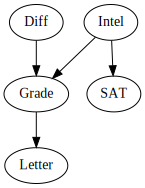

'student_pgm.pdf'

In [12]:
model2 = CausalGraphicalModel(nodes=model.nodes(), edges=model.edges())

dot = model2.draw()
print(type(dot))
display(dot)
dot.render(filename="student_pgm", format="pdf")
# creates student_pgm (a text file of the graph) and student_pgm.pdf

## CPTs

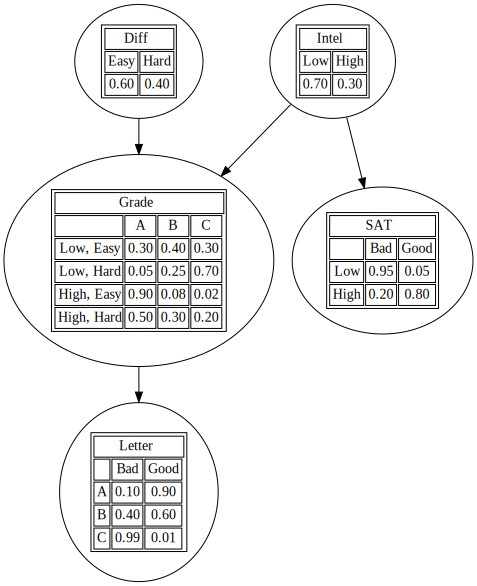

'student_pgm_with_cpt.pdf'

In [14]:
dot = pgm.visualize_model(model)
display(dot)
dot.render("student_pgm_with_cpt", format="pdf")

## Marginals

In [15]:
evidence = {"Grade": "C"}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'Diff': array([0.37070938, 0.62929062]), 'Grade': array([0., 0., 1.]), 'Intel': array([0.92105263, 0.07894737]), 'Letter': array([0.99, 0.01]), 'SAT': array([0.89078947, 0.10921053])}


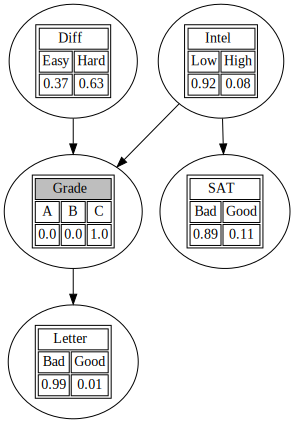

'student_pgm_marginals_given_grade.pdf'

In [16]:
dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)
dot.render("student_pgm_marginals_given_grade", format="pdf")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Diff': array([0.24044002, 0.75955998]), 'Grade': array([0., 0., 1.]), 'Intel': array([0.42168675, 0.57831325]), 'Letter': array([0.99, 0.01]), 'SAT': array([0., 1.])}


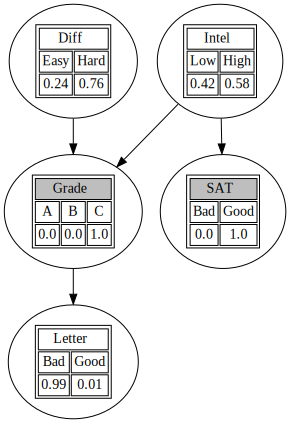

'student_pgm_marginals_given_grade_sat.pdf'

In [17]:
evidence = {"Grade": "C", "SAT": "Good"}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)
dot.render("student_pgm_marginals_given_grade_sat", format="pdf")